# Socio-economic Country Groups 

Dataset Source: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data

Dataset License: https://www.mit.edu/~amini/LICENSE.md

The goal of this project is to cluster countries based on some socio-economic and health factors. The cluster of similar countries that appear to have poor indicators like high child morbidity will be the ones to be provided support.

*Ethical Disclaimer*: This dataset at time of creating this notebook is four years old and may not be representative of the countries current state and wellbeing.



### Load dataset and initial look

In [84]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px 
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# Set random state so the return is consistent
np.random.seed(42)

In [85]:
df = pd.read_csv("data/Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Explanation of features
From observation and provided column description file.
* country
    * The name of the country
    * Categorical/ID
* child_mort
    * Number of children under five years old who die per 1000 live births
    * Numerical, deaths per 1000
* exports
    * Exports of good and services per capita
    * Numerical, percentage of GDP
* health
    * Total health spending per capita
    * Numerical, percentage of GDP
* imports
    * Imports of good and services per capita
    * Numerical, percentage of GP
* income
    * Net income per person
    * Numerical, seems to be normalized to a particular income
* inflation
    * Annual growth rate of the Total GDP
    * Numerical, percentage increase
* life_expec
    * Average expected life span for a newborn 
    * Numerical, years 
* total_fer
    * Average children per woman
    * Numerical, children/offspring count
* gdpp
    * GDP per capita
    * Numerical, total GDP divided by the total population
      
Initially what jumps out is a statistic that more developed nations tend to suffer from decreased fertility and I suspect that will be an interesting feature to focus on or look more into.

### Data Cleanup & Exploration



In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


167 countries are shown and the data seems pretty clean, now need to look at value distributions.

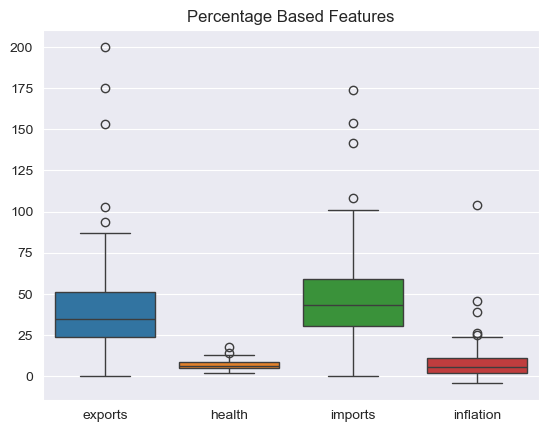

In [87]:
# Boxplot of percentages: exports, health, imports, and inflation
sns.boxplot(df[["exports", "health", "imports", "inflation"]])
plt.title("Percentage Based Features")
plt.show()

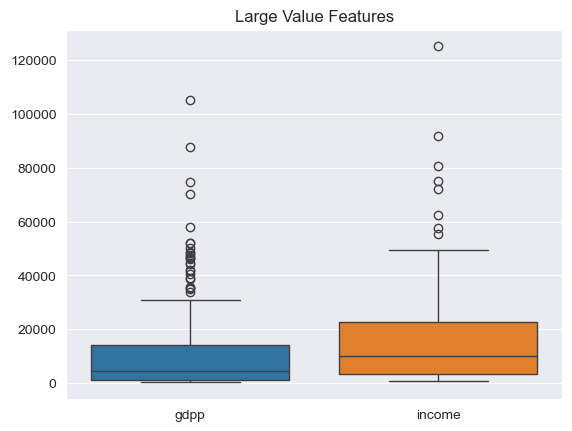

In [88]:
# Boxplot of large value fields: gdpp, and income
sns.boxplot(df[["gdpp", "income"]])
plt.title("Large Value Features")
plt.show()

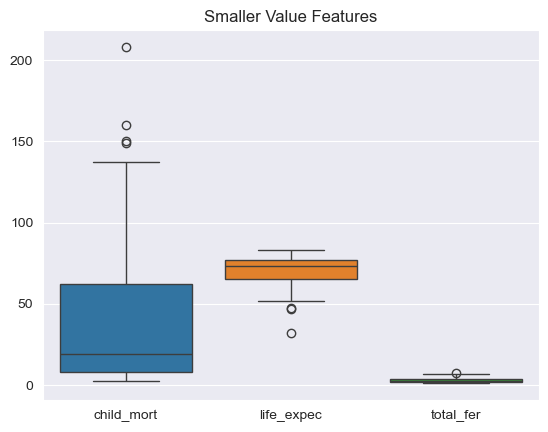

In [89]:
# Boxplot of other fields: child_mort, life_expec, total_fer
sns.boxplot(df[["child_mort", "life_expec", "total_fer"]])
plt.title("Smaller Value Features")
plt.show()

### Outlier analysis
It looks like there are a few outliers that need to be looked at to make sure they're not incorrect.

In [90]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [91]:
# Find max value and corresponding countries
print("Column : Max Value : Country")
for column in df.columns:
    if column == "country":
        continue
    max_value = df[column].max()
    matched_country = ", ".join(df[df[column] == df[column].max()].country.values)
    print(column, ":", max_value, ":", matched_country)

Column : Max Value : Country
child_mort : 208.0 : Haiti
exports : 200.0 : Singapore
health : 17.9 : United States
imports : 174.0 : Singapore
income : 125000 : Qatar
inflation : 104.0 : Nigeria
life_expec : 82.8 : Japan
total_fer : 7.49 : Niger
gdpp : 105000 : Luxembourg


In [92]:
# Find min value and corresponding countries
print("Column : Min Value : Country")
for column in df.columns:
    if column == "country":
        continue
    min_value = df[column].min()
    matched_country = ", ".join(df[df[column] == df[column].min()].country.values)
    print(column, ":", min_value, ":", matched_country)

Column : Min Value : Country
child_mort : 2.6 : Iceland
exports : 0.109 : Myanmar
health : 1.81 : Qatar
imports : 0.0659 : Myanmar
income : 609 : Congo, Dem. Rep.
inflation : -4.21 : Seychelles
life_expec : 32.1 : Haiti
total_fer : 1.15 : Singapore
gdpp : 231 : Burundi


Looking at the max values first we see Haiti with a high child morbidity and unfortunately a cursory search turns up that is what is happening in Haiti. https://www.afd.fr/en/actualites/haiti-continuing-improve-maternal-and-child-health-services
Also inflation seems to stand out, from Nigeria and that also tracks with what is seen in the market from a few years ago.
Next, looking at the min values nothing really stands out as being wrong.

## Model building

* K-means

From https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html we would expect that there should be four distinct groupings, "Low income, lower middle income, upper middle income, and high income" but that doesn't necessarily take into account other factors.



In [93]:
FEATURES_OF_INTEREST = ["exports", "health", "imports", "inflation", "gdpp", "income", "child_mort", "life_expec", "total_fer"]

kmeans_fit = KMeans(n_clusters=4, random_state=42).fit(df[FEATURES_OF_INTEREST])
grouping = kmeans_fit.labels_

kmeans_df = df.copy(deep=True)
kmeans_df["label"] = grouping

grouping

array([0, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0,
       0, 2, 2, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 2, 0, 0, 2,
       0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 0, 0], dtype=int32)

From an initial look seeing four clusters. The cluster label 0 doesn't refer to specific order just the cluster id it is in.

In [94]:
print(kmeans_df.head())
px.choropleth(kmeans_df, locations="country", color="label", locationmode="country names").show()

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  label  
0       9.44        56.2       5.82    553      0  
1       4.49        76.3       1.65   4090      0  
2      16.10        76.5       2.89   4460      0  
3      22.40        60.1       6.16   3530      0  
4       1.44        76.8       2.13  12200      2  


There are some interesting clustering based on location even though there is no geographic data used to create the clusters.

To make sure the outliers aren't affecting the clusters this could lend towards some bad clustering, initially tried to use the StandardScaler, but swapped to RobustScaler since it is stated to handle outliers better

In [98]:
scaled_features = RobustScaler().fit_transform(df[FEATURES_OF_INTEREST])
scaled_features

array([[-0.90744102,  0.3423913 ,  0.05604203, ...,  1.31662024,
        -1.46956522,  1.63549161],
       [-0.25408348,  0.0625    ,  0.18563923, ..., -0.05013928,
         0.27826087, -0.36450839],
       [ 0.12341198, -0.58423913, -0.41681261, ...,  0.14856082,
         0.29565217,  0.23021583],
       ...,
       [ 1.3430127 ,  0.14130435,  1.29246935, ...,  0.07428041,
         0.        , -0.2206235 ],
       [-0.1814882 , -0.30978261, -0.3117338 , ...,  0.68709378,
        -0.48695652,  1.08393285],
       [ 0.07259528, -0.11684783, -0.43432574, ...,  1.18477252,
        -1.83478261,  1.43405276]])

In [99]:
kmeans_scaled_fit = KMeans(n_clusters=4, random_state=42).fit(scaled_features)
grouping = kmeans_scaled_fit.labels_

kmeans_scaled_df = df.copy(deep=True)
kmeans_scaled_df["label"] = grouping

grouping

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       1, 1, 2, 3, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2], dtype=int32)

In [101]:
print(kmeans_scaled_df.head())
px.choropleth(kmeans_scaled_df, locations="country", color="label", locationmode="country names").show()

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  label  
0       9.44        56.2       5.82    553      2  
1       4.49        76.3       1.65   4090      0  
2      16.10        76.5       2.89   4460      0  
3      22.40        60.1       6.16   3530      2  
4       1.44        76.8       2.13  12200      0  


In [108]:
print("Label 2 countries:")
kmeans_scaled_df[kmeans_scaled_df.label==2]

Label 2 countries:


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,10.000,7.58,44.9000,1610,9.440,56.2,5.82,553,2
3,Angola,119.0,62.300,2.85,42.9000,5900,22.400,60.1,6.16,3530,2
17,Benin,111.0,23.800,4.10,37.2000,1820,0.885,61.8,5.36,758,2
21,Botswana,52.5,43.600,8.30,51.3000,13300,8.920,57.1,2.88,6350,2
25,Burkina Faso,116.0,19.200,6.74,29.6000,1430,6.810,57.9,5.87,575,2
26,Burundi,93.6,8.920,11.60,39.2000,764,12.300,57.7,6.26,231,2
28,Cameroon,108.0,22.200,5.13,27.0000,2660,1.910,57.3,5.11,1310,2
31,Central African Republic,149.0,11.800,3.98,26.5000,888,2.010,47.5,5.21,446,2
32,Chad,150.0,36.800,4.53,43.5000,1930,6.390,56.5,6.59,897,2
36,Comoros,88.2,16.500,4.51,51.7000,1410,3.870,65.9,4.75,769,2


In [109]:
print("Label 3 countries:")
kmeans_scaled_df[kmeans_scaled_df.label==3]

Label 3 countries:


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330,3


# Conclusion
After scaling for outliers the new model show a more reasonable clustering of countries. Specifically groups 2 and 3 seem the most interesting that could do better with some targeted funding in order for them to fit more with group 0 and 1 countries. Even though originally I suspected that the clustering would be focused around income groups mentioned earlier, instead it seems to be more inline with clustering of First, Second, and Third World countries.
 
Despite how it sounds, First, Second, and Third World countries instead stemmed from geopolitical groups during the cold-war and would make sense that specific groups would have similar fiscal policies. (https://www.history.com/news/why-are-countries-classified-as-first-second-or-third-world)

In conclusion, we were able to narrow the list of countries from 167 entries to just 51 that seem to need some targeted funding to improve their standard of living. This is based on how the clusters are created based on similarities of each feature.